<a href="https://colab.research.google.com/github/enerdb/Finance_alpha_factors/blob/main/Alpha_factor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports & Settings 

In [1]:
! pip install yfinance --quiet

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
idx = pd.IndexSlice

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 27.6 MB/s eta 0:00:00


# Get Data

We need 2 DataFrames:
* prices: containing the adj_close of stocks (columns) from START to END (rows).
* stocks: Stocks (index) with their actual marketcap, ipo year, and sector.



In [2]:
tickers = "RRRP3	ALSO3	ABEV3	ASAI3	AZUL4	B3SA3	BBSE3	BBDC4	BBAS3	BRFS3	BPAC11	CMIG4	CIEL3	CSAN3	CVCB3	CYRE3	ELET3	ELET6	EQTL3	GGBR4	NTCO3	HAPV3	HYPE3	ITSA4	ITUB4	JBSS3	KLBN11	RENT3	LWSA3	LREN3	MGLU3	MRFG3	MULT3	PETR3	PETR4	PRIO3	PETZ3	RADL3	RDOR3	RAIL3	SBSP3	CSNA3	SUZB3	TOTS3	USIM5	VALE3	VIIA3	VBBR3	WEGE3".split('\t')
tickers = [x + '.SA' for x in tickers]

prices = yf.download(tickers = tickers, period = '5y')['Adj Close']

[*********************100%***********************]  49 of 49 completed


In [3]:
prices = prices.tz_localize(None)

In [4]:
start_time = prices.index[0]

## Create monthly return series

In [5]:
monthly_prices = prices.resample('M').last()

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(n_periods), that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the .stack() method, use .pipe() to apply the .clip() method to the resulting DataFrame, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using .swaplevel() to change the order of the MultiIndex levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [6]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2217 entries, ('ABEV3.SA', Timestamp('2019-02-28 00:00:00', freq='M')) to ('WEGE3.SA', Timestamp('2023-02-28 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1m   2217 non-null   float64
 1   return_2m   2217 non-null   float64
 2   return_3m   2217 non-null   float64
 3   return_6m   2217 non-null   float64
 4   return_9m   2217 non-null   float64
 5   return_12m  2217 non-null   float64
dtypes: float64(6)
memory usage: 112.3+ KB


In [7]:
data.index.rename(['Ticker', 'Date'], inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2217 entries, ('ABEV3.SA', Timestamp('2019-02-28 00:00:00', freq='M')) to ('WEGE3.SA', Timestamp('2023-02-28 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1m   2217 non-null   float64
 1   return_2m   2217 non-null   float64
 2   return_3m   2217 non-null   float64
 3   return_6m   2217 non-null   float64
 4   return_9m   2217 non-null   float64
 5   return_12m  2217 non-null   float64
dtypes: float64(6)
memory usage: 112.3+ KB


## Drop stocks with less than 3 years of returns

Preciso descobrir como trabalhar com os levels dos índices por nome ou já pesquisar o groupby com multiindex

In [9]:
min_obs = 36
nobs = data.groupby(level='Ticker').size()
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2104 entries, ('ABEV3.SA', Timestamp('2019-02-28 00:00:00', freq='M')) to ('WEGE3.SA', Timestamp('2023-02-28 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1m   2104 non-null   float64
 1   return_2m   2104 non-null   float64
 2   return_3m   2104 non-null   float64
 3   return_6m   2104 non-null   float64
 4   return_9m   2104 non-null   float64
 5   return_12m  2104 non-null   float64
dtypes: float64(6)
memory usage: 106.8+ KB


In [10]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,2104.000000,2104.000000,2104.000000,2104.000000,2104.000000,2104.000000
mean,0.012063,0.009821,0.008538,0.009044,0.009162,0.009074
std,0.118656,0.089063,0.073194,0.049609,0.043009,0.037007
min,-0.333767,-0.246274,-0.197658,-0.133659,-0.115391,-0.099777
25%,-0.060006,-0.042092,-0.033427,-0.020473,-0.015068,-0.013482
50%,0.008844,0.011302,0.010019,0.009820,0.007997,0.009642
75%,0.084494,0.063157,0.052875,0.039463,0.035517,0.031347
max,0.378919,0.255013,0.198319,0.139673,0.120911,0.101874


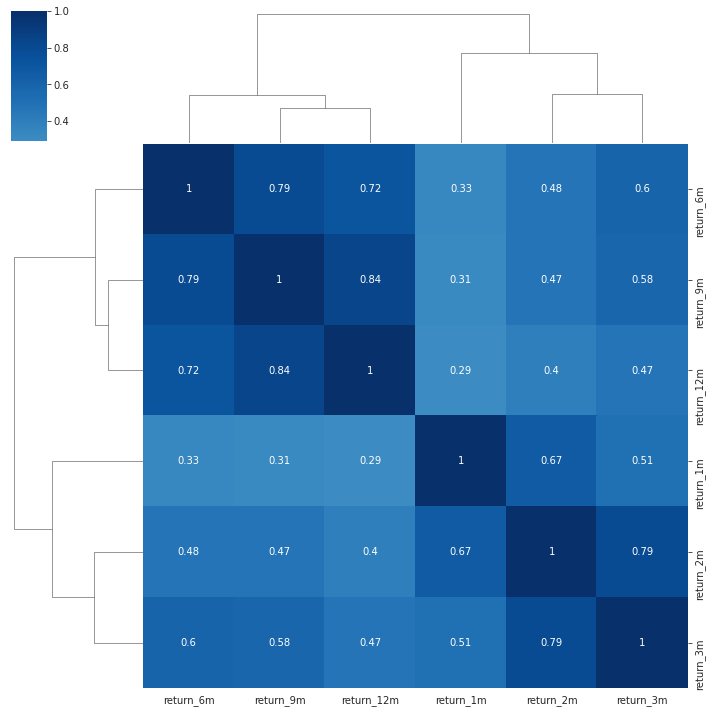

In [11]:
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues');

In [12]:
data.corr('spearman')


,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
return_1m,1.000000,0.667203,0.507936,0.329447,0.311264,0.292833
return_2m,0.667203,1.000000,0.789473,0.475646,0.473773,0.396550
return_3m,0.507936,0.789473,1.000000,0.598397,0.584661,0.472342
return_6m,0.329447,0.475646,0.598397,1.000000,0.792652,0.715923
return_9m,0.311264,0.473773,0.584661,0.792652,1.000000,0.840800
return_12m,0.292833,0.396550,0.472342,0.715923,0.840800,1.000000


Correlações positivas indicam momentum forte. Quem ganha em um prazo menor continua ganhando em prazos maiores.

In [13]:
data.index.get_level_values('Ticker').nunique()

43

# Rolling Factor Betas

The 5 Fama-french factors are:
* Market risk
* Size (SMB = small minus big)
* Value (HML)
* Operationg profitability (RMW)
* Investment (CMA)

We can:
* access the historical factor returns using the pandas-datareader;
* estimate historical exposures using the RollingOLS rolling linear regression functionality in the statsmodels library.

In [14]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2019')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'Date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2019-01-31 to 2022-12-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  48 non-null     float64
 1   SMB     48 non-null     float64
 2   HML     48 non-null     float64
 3   RMW     48 non-null     float64
 4   CMA     48 non-null     float64
dtypes: float64(5)
memory usage: 2.2 KB


In [16]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2018 entries, ('ABEV3.SA', Timestamp('2019-02-28 00:00:00', freq='M')) to ('WEGE3.SA', Timestamp('2022-12-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Mkt-RF     2018 non-null   float64
 1   SMB        2018 non-null   float64
 2   HML        2018 non-null   float64
 3   RMW        2018 non-null   float64
 4   CMA        2018 non-null   float64
 5   return_1m  2018 non-null   float64
dtypes: float64(6)
memory usage: 101.5+ KB


In [17]:
T = 24
betas = (factor_data.groupby(level='Ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))

In [18]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,2018.000000
mean,1.029142,-0.060955,0.299210,-0.328785,0.356428,0.660355
std,0.509792,0.858769,0.595404,1.131895,1.160581,1.500011
min,-0.200157,-2.447821,-1.878011,-5.083085,-3.452196,-4.630765
25%,0.714488,-0.620885,-0.112092,-0.992246,-0.336734,0.000000
50%,0.959251,-0.039148,0.313792,-0.210987,0.418415,0.000000
75%,1.224837,0.490725,0.728737,0.378762,1.122414,1.327687
max,3.129914,3.355225,2.042647,3.644935,4.115289,6.091097


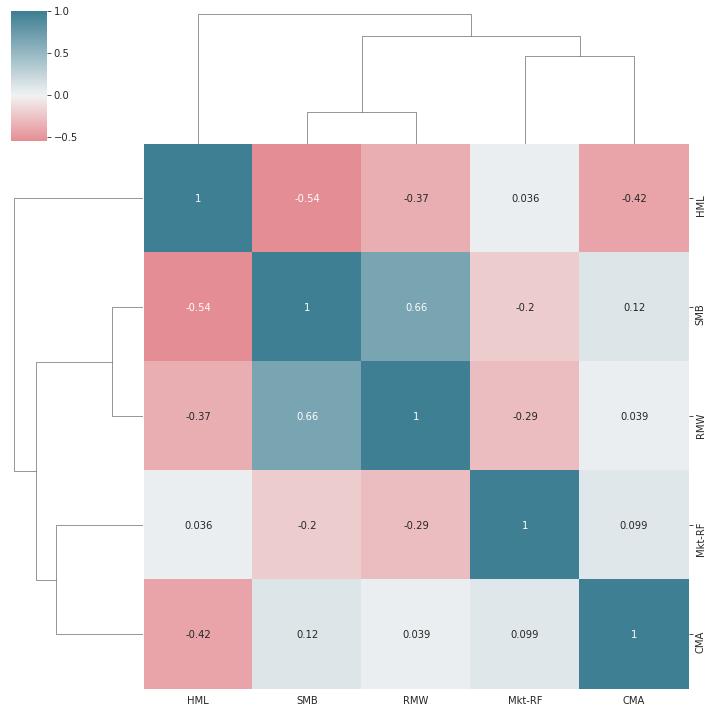

In [19]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [20]:
data = (data
        .join(betas
              .groupby(level='Ticker')
              .shift()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2104 entries, ('ABEV3.SA', Timestamp('2019-02-28 00:00:00', freq='M')) to ('WEGE3.SA', Timestamp('2023-02-28 00:00:00', freq='M'))
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1m   2104 non-null   float64
 1   return_2m   2104 non-null   float64
 2   return_3m   2104 non-null   float64
 3   return_6m   2104 non-null   float64
 4   return_9m   2104 non-null   float64
 5   return_12m  2104 non-null   float64
 6   Mkt-RF      986 non-null    float64
 7   SMB         986 non-null    float64
 8   HML         986 non-null    float64
 9   RMW         986 non-null    float64
 10  CMA         986 non-null    float64
dtypes: float64(11)
memory usage: 253.5+ KB


## Impute mean for missing factor betas

In [21]:
data.loc[:, factors] = data.groupby('Ticker')[factors].apply(lambda x: x.fillna(x.mean()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2104 entries, ('ABEV3.SA', Timestamp('2019-02-28 00:00:00', freq='M')) to ('WEGE3.SA', Timestamp('2023-02-28 00:00:00', freq='M'))
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1m   2104 non-null   float64
 1   return_2m   2104 non-null   float64
 2   return_3m   2104 non-null   float64
 3   return_6m   2104 non-null   float64
 4   return_9m   2104 non-null   float64
 5   return_12m  2104 non-null   float64
 6   Mkt-RF      2104 non-null   float64
 7   SMB         2104 non-null   float64
 8   HML         2104 non-null   float64
 9   RMW         2104 non-null   float64
 10  CMA         2104 non-null   float64
dtypes: float64(11)
memory usage: 253.5+ KB


#Momentum factors

In [23]:
for lag in [2,3,6,9,12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)

# Date indicators

In [25]:
dates = data.index.get_level_values('Date')
data['year'] = dates.year
data['month'] = dates.month

#Lagged returns

In [26]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='Ticker').return_1m.shift(t)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2104 entries, ('ABEV3.SA', Timestamp('2019-02-28 00:00:00', freq='M')) to ('WEGE3.SA', Timestamp('2023-02-28 00:00:00', freq='M'))
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   return_1m      2104 non-null   float64
 1   return_2m      2104 non-null   float64
 2   return_3m      2104 non-null   float64
 3   return_6m      2104 non-null   float64
 4   return_9m      2104 non-null   float64
 5   return_12m     2104 non-null   float64
 6   Mkt-RF         2104 non-null   float64
 7   SMB            2104 non-null   float64
 8   HML            2104 non-null   float64
 9   RMW            2104 non-null   float64
 10  CMA            2104 non-null   float64
 11  momentum_2     2104 non-null   float64
 12  momentum_3     2104 non-null   float64
 13  momentum_6     2104 non-null   float64
 14  momentum_9     2104 non-null   float64
 15  momentum_12    2104 non-null   fl

# Target: Holding Period Returns

In [29]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = data.groupby(level='Ticker')[f'return_{t}m'].shift(-t)

In [30]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 
        'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m  return_2m  \
Ticker   Date                                                                
ABEV3.SA 2019-05-31   0.019373   0.070985   0.021746  -0.049811   0.021166   
         2019-06-30   0.125210   0.022934   0.024724   0.019373  -0.015826   
         2019-07-31  -0.070045  -0.022102  -0.047784   0.125210   0.070985   
         2019-08-31   0.028312  -0.036455  -0.012075  -0.070045   0.022934   
         2019-09-30  -0.097143  -0.031670  -0.001555   0.028312  -0.022102   
         2019-10-31   0.038550   0.049970   0.017691  -0.097143  -0.036455   
         2019-11-30   0.061516   0.007419  -0.061469   0.038550  -0.031670   
         2019-12-31  -0.043921  -0.117510  -0.138919   0.061516   0.049970   
         2020-01-31  -0.185434  -0.182818  -0.140343  -0.043921   0.007419   
         2020-02-29  -0.180193  -0.116871  -0.049650  -0.185434  -0.117510   

                     return_3m  return_1m_t-1  return_1m_t-2  return_1m_t-3  
Ticker   Date                                                                
ABEV3.SA 2019-05-31   0.006153       0.097445      -0.023215      -0.015991  
         2019-06-30   0.020568      -0.049811       0.097445      -0.023215  
         2019-07-31   0.029103       0.019373      -0.049811       0.097445  
         2019-08-31   0.021746       0.125210       0.019373      -0.049811  
         2019-09-30   0.024724      -0.070045       0.125210       0.019373  
         2019-10-31  -0.047784       0.028312      -0.070045       0.125210  
         2019-11-30  -0.012075      -0.097143       0.028312      -0.070045  
         2019-12-31  -0.001555       0.038550      -0.097143       0.028312  
         2020-01-31   0.017691       0.061516       0.038550      -0.097143  
         2020-02-29  -0.061469      -0.043921       0.061516       0.038550

# Other
The book still lists age proxy, and size indicator as deciles per period. It is not done here as I did not get this data from brazilian stocks.




# Store data

In [36]:
data.sort_index().loc[idx[:, :datetime.now()], :].to_csv('engineered_features.csv')

# Dummy variables for modeling

In [38]:
data.columns

Index(['return_1m', 'return_2m', 'return_3m', 'return_6m', 'return_9m',
       'return_12m', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'momentum_2',
       'momentum_3', 'momentum_6', 'momentum_9', 'momentum_12',
       'momentum_3_12', 'year', 'month', 'return_1m_t-1', 'return_1m_t-2',
       'return_1m_t-3', 'return_1m_t-4', 'return_1m_t-5', 'return_1m_t-6',
       'target_1m', 'target_2m', 'target_3m', 'target_6m', 'target_12m'],
      dtype='object')

In [39]:
dummy_data = pd.get_dummies(data,
                            columns=['year','month'],
                            prefix=['year','month'],
                            prefix_sep=['_', '_'])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2104 entries, ('ABEV3.SA', Timestamp('2019-02-28 00:00:00', freq='M')) to ('WEGE3.SA', Timestamp('2023-02-28 00:00:00', freq='M'))
Data columns (total 45 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   return_1m      2104 non-null   float64
 1   return_2m      2104 non-null   float64
 2   return_3m      2104 non-null   float64
 3   return_6m      2104 non-null   float64
 4   return_9m      2104 non-null   float64
 5   return_12m     2104 non-null   float64
 6   Mkt-RF         2104 non-null   float64
 7   SMB            2104 non-null   float64
 8   HML            2104 non-null   float64
 9   RMW            2104 non-null   float64
 10  CMA            2104 non-null   float64
 11  momentum_2     2104 non-null   float64
 12  momentum_3     2104 non-null   float64
 13  momentum_6     2104 non-null   float64
 14  momentum_9     2104 non-null   float64
 15  momentum_12    2104 non-null   fl